#### Summary
This time around, per commit `352e6fb` , I'm using a training loop, where the weights applied to the loss function calculation, dynamically is set based on which was the previous loss.

The training loss, now I'm plotting the loss of each label in the batch separately, looks very different. 

But the validation still follows the same pattern unfortunately where the `label=1` loss gets favored.

In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()


In [3]:
# Working dir... for new model
save_dir = 'history'
ts = mu.quickts(); print('starting,', ts)

workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

starting, 2020-01-19T180030Z
Made new workdir, history/2020-01-19T180030Z


In [4]:
lstm_params = [{
    'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (None, 64, 8),
    'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                           #tf.initializers.he_normal()
    },

]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

def bake_model(lstm_params):

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [5]:

BATCH_SIZE = 32
EPOCHS = 1
# Use datasets from 
# 2019-12-25.ipynb
# 
# train ... new datasets, ...
datadir = 'history/2019-12-22T174803Z'
# train_loc = f'{datadir}/train_balanced.h5'
test_loc = f'{datadir}/test_balanced.h5'
train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'
print(mu.h5_keys(train_shuff_loc))
print(mu.h5_keys(test_loc))

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
model = bake_model(lstm_params)
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')



['X', 'Ylabels']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [40]:
reload(mu)

<module 'mytf.utils' from '/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py'>

In [41]:
%%time
modelloc = f'{workdir}/00000__unfitted_model.h5'
print(f'Start train with {modelloc}')
model = mu.load_model(modelloc)

class_weights = {0: 1., 1: 0., 2: 0., 3: 0.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
ipdb.runcall(mu.do_train,
        model,
        dataset_batches,
        k=size,
        epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)

Start train with history/2020-01-19T180030Z/00000__unfitted_model.h5
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(254)do_train()
    253 def do_train(model, dataset_batches, k, epochs, optimizer_params, saveloc):
--> 254     optimizer = AdamOptimizer(**optimizer_params)
    255 

ipdb> unt
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(256)do_train()
    255 
--> 256     loss_history = []
    257     label_losses_history = []

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(257)do_train()
    256     loss_history = []
--> 257     label_losses_history = []
    258 

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(260)do_train()
    259     #weights = tf.constant(np.ones((32, 1)))
--> 260     weights_dict = {0: 1., 1: 1., 2: 1., 3:1.}
    261     for epoch in range(epochs):

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(261)do_train()
    260     w








0it [00:00, ?it/s]

> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(264)do_train()
    263         for (batch, (invec, labels, _)) in enumerate(tqdm(dataset_batches.take(k))):
--> 264             weights = np.array([weights_dict[labels[i].numpy()] for i in range(32)])
    265 

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(268)do_train()
    267             # NOTE: is this tape in the right place?
--> 268             with tf.GradientTape() as tape:
    269                 logits = model(invec, training=True)

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(269)do_train()
    268             with tf.GradientTape() as tape:
--> 269                 logits = model(invec, training=True)
    270                 loss_value = sparse_softmax_cross_entropy(labels, logits, weights=weights)

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(270)do_train()
    269                 logits = model(invec, train

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(293)do_train()
    292 
--> 293             if batch % 10 == 0:
    294                 save_model(model, (f'{prefix}_model.h5'))

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(294)do_train()
    293             if batch % 10 == 0:
--> 294                 save_model(model, (f'{prefix}_model.h5'))
    295 

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(296)do_train()
    295 
--> 296                 to_json_local(loss_history,
    297                             f'{prefix}_train_loss_history.json')

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(297)do_train()
    296                 to_json_local(loss_history,
--> 297                             f'{prefix}_train_loss_history.json')
    298 

ipdb> 
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(299)do_train()
    298 
--> 299                 








1it [01:05, 65.96s/it]






2it [01:06, 46.48s/it]






3it [01:07, 32.83s/it]






4it [01:09, 23.33s/it]






5it [01:10, 16.62s/it]






6it [01:11, 11.93s/it]






7it [01:12,  8.64s/it]






8it [01:13,  6.34s/it]






9it [01:13,  4.73s/it]






10it [01:14,  3.61s/it]






11it [01:15,  2.83s/it]






12it [01:17,  2.28s/it]






13it [01:18,  1.94s/it]






14it [01:19,  1.65s/it]






15it [01:20,  1.45s/it]






16it [01:21,  1.31s/it]






17it [01:22,  1.22s/it]






18it [01:23,  1.14s/it]






19it [01:24,  1.09s/it]






20it [01:24,  1.05s/it]






21it [01:25,  1.03s/it]






22it [01:27,  1.06s/it]






23it [01:28,  1.03s/it]






24it [01:29,  1.01s/it]






25it [01:30,  1.01s/it]






26it [01:31,  1.00s/it]






27it [01:32,  1.00s/it]






28it [01:32,  1.01it/s]






29it [01:33,  1.01it/s]






30it [01:34,  1.02it/s]






31it [01:36,  1.01s/it]






32it [01:36,  1.01it/s]






33it [01:37,  1.02it/s]






34it [01:38,

160it [03:46,  1.01it/s]






161it [03:47,  1.00it/s]






162it [03:48,  1.01it/s]






163it [03:49,  1.02it/s]






164it [03:50,  1.03it/s]






165it [03:51,  1.01s/it]






166it [03:52,  1.00it/s]






167it [03:53,  1.01it/s]






168it [03:54,  1.02it/s]






169it [03:54,  1.03it/s]






170it [03:55,  1.04it/s]






171it [03:56,  1.02it/s]






172it [03:57,  1.03it/s]






173it [03:58,  1.03it/s]






174it [03:59,  1.01s/it]






175it [04:00,  1.01it/s]






176it [04:01,  1.01s/it]






177it [04:02,  1.01s/it]






178it [04:03,  1.00s/it]






179it [04:04,  1.01it/s]






180it [04:05,  1.01it/s]






181it [04:06,  1.00s/it]






182it [04:07,  1.00s/it]






183it [04:09,  1.04s/it]






184it [04:10,  1.02s/it]






185it [04:11,  1.02s/it]






186it [04:12,  1.01s/it]






187it [04:13,  1.00it/s]






188it [04:14,  1.01it/s]






189it [04:14,  1.01it/s]






190it [04:15,  1.02it/s]






191it [04:17,  1.04s/it]






192it [0

317it [06:22,  1.01it/s]






318it [06:23,  1.01it/s]






319it [06:24,  1.03s/it]






320it [06:25,  1.01s/it]






321it [06:26,  1.02s/it]






322it [06:27,  1.00s/it]






323it [06:28,  1.01it/s]






324it [06:29,  1.02it/s]






325it [06:30,  1.02it/s]






326it [06:31,  1.02s/it]






327it [06:33,  1.28s/it]






328it [06:34,  1.36s/it]






329it [06:35,  1.24s/it]






330it [06:36,  1.17s/it]






331it [06:37,  1.13s/it]






332it [06:38,  1.07s/it]






333it [06:39,  1.04s/it]






334it [06:40,  1.01s/it]






335it [06:41,  1.00it/s]






336it [06:42,  1.03s/it]






337it [06:43,  1.01s/it]






338it [06:44,  1.01it/s]






339it [06:45,  1.02it/s]






340it [06:46,  1.02it/s]






341it [06:47,  1.01it/s]






342it [06:48,  1.01it/s]






343it [06:49,  1.01it/s]






344it [06:50,  1.01it/s]






345it [06:51,  1.04s/it]






346it [06:52,  1.01s/it]






347it [06:53,  1.01it/s]






348it [06:54,  1.02it/s]






349it [0

474it [09:00,  1.02s/it]






475it [09:01,  1.02s/it]






476it [09:03,  1.03s/it]






477it [09:04,  1.03s/it]






478it [09:05,  1.01s/it]






479it [09:05,  1.00s/it]






480it [09:06,  1.01it/s]






481it [09:08,  1.07s/it]






482it [09:09,  1.04s/it]






483it [09:10,  1.03s/it]






484it [09:11,  1.02s/it]






485it [09:12,  1.01s/it]






486it [09:13,  1.00s/it]






487it [09:14,  1.00it/s]






488it [09:15,  1.04s/it]






489it [09:16,  1.02s/it]






490it [09:17,  1.01s/it]






491it [09:18,  1.04s/it]






492it [09:19,  1.02s/it]






493it [09:20,  1.02s/it]






494it [09:21,  1.01s/it]






495it [09:22,  1.01s/it]






496it [09:23,  1.00s/it]






497it [09:24,  1.04s/it]






498it [09:25,  1.03s/it]






499it [09:26,  1.02s/it]






500it [09:27,  1.01s/it]






501it [09:28,  1.03s/it]






502it [09:29,  1.02s/it]






503it [09:30,  1.01s/it]






504it [09:31,  1.14s/it]






505it [09:33,  1.31s/it]






506it [0

631it [11:40,  1.00s/it]






632it [11:41,  1.01it/s]






633it [11:42,  1.03s/it]






634it [11:43,  1.01s/it]






635it [11:44,  1.01s/it]






636it [11:45,  1.00it/s]






637it [11:46,  1.01it/s]






638it [11:47,  1.01it/s]






639it [11:48,  1.01it/s]






640it [11:49,  1.03it/s]






641it [11:50,  1.05s/it]






642it [11:51,  1.02s/it]






643it [11:52,  1.01s/it]






644it [11:53,  1.00it/s]






645it [11:54,  1.02it/s]






646it [11:55,  1.02it/s]






647it [11:56,  1.03it/s]






648it [11:57,  1.04it/s]






649it [11:58,  1.04it/s]






650it [11:59,  1.00it/s]






651it [12:00,  1.02s/it]






652it [12:01,  1.01s/it]






653it [12:02,  1.03s/it]






654it [12:03,  1.03s/it]






655it [12:04,  1.00s/it]






656it [12:05,  1.01it/s]






657it [12:06,  1.00it/s]






658it [12:07,  1.01it/s]






659it [12:08,  1.04s/it]






660it [12:09,  1.02s/it]






661it [12:10,  1.05s/it]






662it [12:11,  1.02s/it]






663it [1

788it [14:20,  1.01s/it]






789it [14:21,  1.01s/it]






790it [14:22,  1.00s/it]






791it [14:23,  1.04s/it]






792it [14:24,  1.03s/it]






793it [14:26,  1.06s/it]






794it [14:27,  1.05s/it]






795it [14:28,  1.03s/it]






796it [14:28,  1.01s/it]






797it [14:29,  1.00it/s]






798it [14:30,  1.01it/s]






799it [14:31,  1.00it/s]






800it [14:32,  1.01it/s]






801it [14:34,  1.03s/it]






802it [14:35,  1.05s/it]






803it [14:36,  1.03s/it]






804it [14:37,  1.01s/it]






805it [14:38,  1.00it/s]






806it [14:38,  1.01it/s]






807it [14:39,  1.02it/s]






808it [14:40,  1.03it/s]






809it [14:42,  1.01s/it]






810it [14:42,  1.00s/it]






811it [14:44,  1.03s/it]






812it [14:45,  1.01s/it]






813it [14:46,  1.01it/s]






814it [14:46,  1.02it/s]






815it [14:47,  1.02it/s]






816it [14:48,  1.02it/s]






817it [14:49,  1.03it/s]






818it [14:51,  1.02s/it]






819it [14:52,  1.02s/it]






820it [1

945it [17:02,  1.04s/it]






946it [17:03,  1.10s/it]






947it [17:04,  1.07s/it]






948it [17:05,  1.04s/it]






949it [17:06,  1.03s/it]






950it [17:07,  1.02s/it]






951it [17:08,  1.07s/it]






952it [17:09,  1.10s/it]






953it [17:10,  1.06s/it]






954it [17:11,  1.03s/it]






955it [17:12,  1.02s/it]






956it [17:13,  1.01s/it]






957it [17:14,  1.00it/s]






958it [17:15,  1.00it/s]






959it [17:16,  1.00it/s]






960it [17:17,  1.04s/it]






961it [17:18,  1.08s/it]






962it [17:19,  1.05s/it]






963it [17:20,  1.04s/it]






964it [17:21,  1.02s/it]






965it [17:22,  1.01s/it]






966it [17:23,  1.01s/it]






967it [17:24,  1.01s/it]






968it [17:25,  1.00it/s]






969it [17:26,  1.03s/it]






970it [17:27,  1.01s/it]






971it [17:28,  1.05s/it]






972it [17:29,  1.02s/it]






973it [17:30,  1.01s/it]






974it [17:31,  1.01s/it]






975it [17:32,  1.01s/it]






976it [17:33,  1.01it/s]






977it [1

--Return--
None
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(264)do_train()
    263         for (batch, (invec, labels, _)) in enumerate(tqdm(dataset_batches.take(k))):
--> 264             weights = np.array([weights_dict[labels[i].numpy()] for i in range(32)])
    265 

ipdb> n


InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

Encountering this kind of error when slicing tensors in the new `do_train` adaptation.
```
InvalidArgumentError                      Traceback (most recent call last)
InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

```
Basically got around this using the `tensor.numpy()` to be able to slice.

#### some useful debugging setup..
```python
weights_dict = {0: 1., 1: 1., 2: 1., 3:1.}
k = size
for (batch, (invec, labels, _)) in enumerate(tqdm(dataset_batches.take(k))):
    break
    

weights = np.array([weights_dict[labels[i].numpy()] for i in range(32)])

logits = model(invec, training=True)

indices_vec = [ [ i for i in range(32) if labels[i].numpy() == label ] 
               for label in [0, 1, 2, 3] ]

losses = [
sparse_softmax_cross_entropy(labels.numpy()[indices],
            logits.numpy()[indices],
            weights=weights[indices])

        for indices in indices_vec
        ]
weights_dict = mu.weights_for_losses(losses)
```

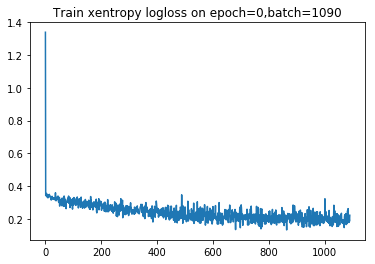

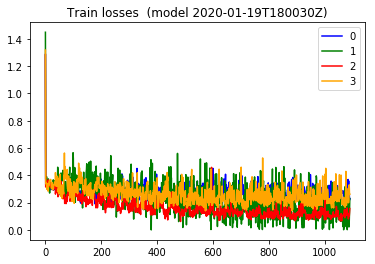

In [44]:

# Look at a most recent train loss plot
historydir = 'history'
with open(f'{workdir}/epoch_000_batch_01090_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 
plt.title('Train xentropy logloss on epoch=0,batch=1090')
plt.show()

# Also plot the individual label losses...
with open(f'{workdir}/epoch_000_batch_01090_train_label_losses_history.json') as fd:
    train_batch_losses_vec = json.load(fd)
    
plt.plot([x[0] for x in train_batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in train_batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in train_batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in train_batch_losses_vec], color='orange', label='3')
#plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'Train losses  (model {ts})')
plt.legend()     
        

In [45]:
epoch = 0
print(len(list(np.arange(0, 1100, 200))))
for batch in tqdm(list(np.arange(0, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))









100%|██████████| 6/6 [00:00<00:00, 12912.17it/s]A

6
history/2020-01-19T180030Z/epoch_000_batch_00000_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00400_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00600_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00800_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_01000_model.h5 True


#### also
* It may help to try the logit plotting technique [from here](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2020-01-10-confidence.md) also

In [46]:
print('starting validation', mu.quickts())
batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(0, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        









  0%|          | 0/6 [00:00<?, ?it/s]

starting validation 2020-01-19T194804Z
history/2020-01-19T180030Z/epoch_000_batch_00000_model.h5 True


AttributeError: module 'mytf.validation' has no attribute 'json_save'

In [47]:
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')

In [48]:
print('saved first one to ',f'{prefix}_validation_losses.json' )

saved first one to  history/2020-01-19T180030Z/epoch_000_batch_00000_validation_losses.json


In [49]:
## ok since that other one crashed at bad file, restarting from iteration 2...

epoch = 0
print(len(list(np.arange(200, 1100, 200))))
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))










100%|██████████| 5/5 [00:00<00:00, 11055.10it/s]A

5
history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00400_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00600_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00800_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_01000_model.h5 True











  0%|          | 0/5 [00:00<?, ?it/s]

starting validation 2020-01-19T195905Z
history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True











 20%|██        | 1/5 [05:49<23:19, 349.85s/it]

history/2020-01-19T180030Z/epoch_000_batch_00400_model.h5 True











 40%|████      | 2/5 [11:38<17:28, 349.50s/it]

history/2020-01-19T180030Z/epoch_000_batch_00600_model.h5 True











 60%|██████    | 3/5 [17:28<11:39, 349.65s/it]

history/2020-01-19T180030Z/epoch_000_batch_00800_model.h5 True











 80%|████████  | 4/5 [23:16<05:49, 349.26s/it]

history/2020-01-19T180030Z/epoch_000_batch_01000_model.h5 True











100%|██████████| 5/5 [29:05<00:00, 349.19s/it]

done validation 2020-01-19T202811Z


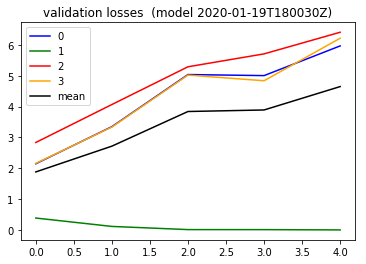

In [50]:
print('starting validation', mu.quickts())
batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        

#### hmm
Dang so this new method 